<a href="https://colab.research.google.com/github/dmamur/elembert/blob/main/embed_mat2spec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ase
import pickle,re, glob,os,random,json
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Embedding,Dense,Dropout,Input,Concatenate,Flatten,Bidirectional,LSTM,Reshape
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
import keras.backend as K
from collections import defaultdict
from scipy.spatial.distance import cdist
from ase.io import read
from ase import Atoms
from scipy.ndimage import gaussian_filter1d
from ase.neighborlist import neighbor_list
def getpdf(atoms):
    r = np.arange(0,10,0.1)
    v = np.concatenate([[1],4*np.pi/3*(r[1:]**3 - r[:-1]**3)])
    i, d = neighbor_list('id', atoms, 10.0, self_interaction=False)
    pdfatoms=[]
    for k,l in enumerate(atoms):
        y = np.zeros(100)
        dist = np.round(d[i==k]*10)
        a,b=np.unique(dist, return_counts=True)
        np.put(y,a.astype(int)-1,b)
        pdfatoms.append(gaussian_filter1d(y/v,1))
    return np.asarray(pdfatoms)

def getTypesXYZ(file):
    xyz=[]
    types=[]
    lattice=file['structure']['lattice']['matrix']
    for n in file['structure']['sites']:
        types.append(n['label'])
        xyz.append(n['xyz'])
        #print(n['label'],n['xyz'])
    return types,lattice,np.asarray(xyz)


In [2]:
!git clone https://github.com/dmamur/struct2prop.git

fatal: destination path 'struct2prop' already exists and is not an empty directory.


In [3]:
class Config:
    MAX_LEN = 128
    BATCH_SIZE = 32
    LR = 0.001
    VOCAB_SIZE = 128
    EMBED_DIM = 128
    MNAME = 'embed_mat2spec_'
config = Config()
path="/content/struct2prop/models"
mname=path+config.MNAME+'E_'+str(config.EMBED_DIM)
tf.random.set_seed(42)

# Load data from zip

In [4]:
%%time
# Check if the pickle file already exists
pickle_file_path = "/content/Mat2Spec_DATA/trainData_Mat2Spec.pkl"
if not os.path.isfile(pickle_file_path):
    if not os.path.isfile('/content/Mat2Spec_DATA.zip'):
    # Download and extract data
      !wget https://data.caltech.edu/records/y7nkc-g8k29/files/Mat2Spec_DATA.zip
      !unzip -q Mat2Spec_DATA.zip

    # Read the CSV file containing mpids
    df0 = pd.read_csv('/content/Mat2Spec_DATA/label_edos/mpids.csv')
    mpids = df0['mpid'].to_list()
    count = 0

    Cell, Types, Xyz, Label, rdfs, dosV, dosE = [], [], [], [], [], [], []

    # Process each mpid
    for n1 in mpids:
        n = f'/content/Mat2Spec_DATA/materials_with_edos/dos_{n1}.json'
        with open(n) as f:
            structure = json.load(f)

        # Extract types, lattice, and coordinates
        types, lattice, coords = getTypesXYZ(structure)
        atoms=Atoms(symbols=types,positions=coords,pbc='True',cell=lattice)
        rdfs.append(getpdf(atoms))
        # Append data to respective lists
        Types.append(types)
        Cell.append(lattice)
        Xyz.append(coords)
        dosE.append(structure['original_dos'][0])
        dosV.append(structure['original_dos'][1])
        count += 1
        if ((count % 1000)==0):
            print('Structure: ',count)

        # Calculate rdf for each coordinate and store in rdfs

    # Create a dictionary to store the data
    db = {
        'types': Types,
        'pdf': rdfs,
        'Cell': Cell,
        'xyz': Xyz,
        'dosE': dosE,
        'dosV': dosV,
        'ids': mpids,
    }

    # Save the dictionary as a pickle file
    with open(pickle_file_path, "wb") as f:
        pickle.dump(db, f)

CPU times: user 276 µs, sys: 39 µs, total: 315 µs
Wall time: 5.55 ms


In [5]:
with open(pickle_file_path, "rb") as f:
    db = pickle.load(f)

types = db['types']
pdf = db['pdf']
ids = db['ids']
del db

In [6]:
edosdat = np.load('/content/Mat2Spec_DATA/label_edos/total_dos_128.npy')

In [7]:
# Load dictionary
with open('/content/struct2prop/data/el2id.pkl', 'rb') as f:
    el2id = pickle.load(f)
element2id = el2id['el2id']
config.VOCAB_SIZE = len(element2id)
print(config.VOCAB_SIZE)

94


In [8]:
# Convert element labels to numerical IDs
typesNumerical = [[element2id[element] for element in row] for row in types]

# Pad sequences for pdf (assuming pdf is a list of arrays)
x1 = tf.keras.preprocessing.sequence.pad_sequences(pdf, dtype='float32', padding='post', truncating='post', maxlen=config.MAX_LEN)

# Pad sequences for typesNumerical
x3 = tf.keras.preprocessing.sequence.pad_sequences(typesNumerical, dtype='int32', padding='post', truncating='post', maxlen=config.MAX_LEN)


In [9]:
y  = tf.keras.preprocessing.sequence.pad_sequences((edosdat - edosdat.min()) / (edosdat.max() - edosdat.min()),dtype='float32',padding= 'post',truncating='post')
p = np.random.RandomState(seed=73).permutation(y.shape[0])
n = len(p)
#trainidx = p[:int(n*0.8)]
#validx = p[int(n*0.8):int(n*0.9)]
#testidx = p[int(n*0.9):]

trainidx = json.load(open('/content/Mat2Spec_DATA/label_edos/train_idx.json'))
validx   = json.load(open('/content/Mat2Spec_DATA/label_edos/validate_idx.json'))
testidx  = json.load(open('/content/Mat2Spec_DATA/label_edos/test_idx.json'))

# Predict eDOS

In [10]:
# Input layer for x1
inputA = Input(shape=x1.shape[1:], name='x1')

# Input layer for types (assuming types have integer values)
inputC = Input((config.MAX_LEN,), dtype=tf.int32, name='types')

# Output layer neuron count
outNeuronNum = y.shape[1]

# Input layer for outNeuronNum
inputD = Input(shape=outNeuronNum)

# LSTM layer for x1
x = Bidirectional(LSTM(8, name='x1_lstm', return_sequences=True), name='x1_blstm')(inputA)
x = Model(inputs=inputA, outputs=x)

# Embedding layer for types
z = Embedding(config.VOCAB_SIZE, config.EMBED_DIM, mask_zero=True, name="element_embdgs")(inputC)
z = Model(inputs=inputC, outputs=z)

# Concatenate the output of x and z
combined = Concatenate()([x.output, z.output])

# LSTM layer on the concatenated output
l = LSTM(256)(combined)

# Dense layer for the final output
e = Dense(outNeuronNum, activation="relu", use_bias=True, name='out_edos')(l)

# Create the final model
model = Model(inputs=[x.input, z.input], outputs=[e])

# Modify the model name
mname = mname + '_eDOS'

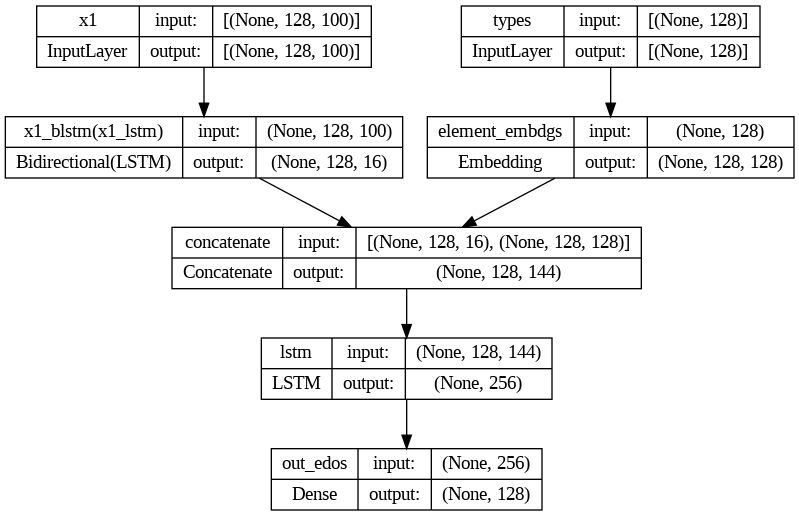

In [11]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [12]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 x1 (InputLayer)             [(None, 128, 100)]           0         []                            
                                                                                                  
 types (InputLayer)          [(None, 128)]                0         []                            
                                                                                                  
 x1_blstm (Bidirectional)    (None, 128, 16)              6976      ['x1[0][0]']                  
                                                                                                  
 element_embdgs (Embedding)  (None, 128, 128)             12032     ['types[0][0]']               
                                                                                            

In [13]:
model.compile(loss ='mae',
              optimizer= keras.optimizers.Adam(learning_rate=config.LR),
              metrics='mse')

In [14]:
def scheduler(epoch):
    initial_lrate = config.LR
    drop = 0.92
    epochs_drop = 48
    lr = initial_lrate * np.power(drop, np.floor((1+epoch)/epochs_drop))

    return max(lr, 0.0001)

if os.path.isfile(mname+"_log.csv"):
    df = pd.read_csv(mname+"_log.csv")
    initEp = df['epoch'].to_numpy()[-1]+1
    model.load_weights(mname+".h5")
else:
    initEp = 0


# Define callback functions
csv_logger = tf.keras.callbacks.CSVLogger(mname + "_log.csv", append=True)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=50, min_delta=0.01)
checkpoint = tf.keras.callbacks.ModelCheckpoint(mname + ".h5", verbose=2, monitor='val_loss', mode='min', save_freq=5000)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

# Combine all callbacks into a list
callbacks_list = [checkpoint, csv_logger, early_stopping, lr_scheduler]

# Training configuration
epochs = 6 * config.BATCH_SIZE
batch_size = 32

# Train the model
hist = model.fit(x=[x1[trainidx], x3[trainidx]], y=[y[trainidx]], validation_data=([x1[validx], x3[validx]], [y[validx]]),
                 initial_epoch=initEp, epochs=epochs, batch_size=batch_size, callbacks=callbacks_list, verbose=1)


In [15]:

# Make predictions
preds = model.predict([x1, x3], batch_size=32)

# Create results dictionary
dbresults = {
    'x4': np.asarray([np.linspace(-4, 4, 128) for _ in range(len(y))]),
    'y': edosdat,
    'preds': preds * (edosdat.max() - edosdat.min()) + edosdat.min(),
    'train_idx': trainidx,
    'validate_idx': validx,
    'test_idx': testidx,
    'ids': ids
}

# Save results to a pickle file
with open(f'{mname}_results.pkl', 'wb') as f:
    pickle.dump(dbresults, f)


1209/1209 [==============================] - 23s 11ms/step


MSE_test:  84.39964901200328 MAE_test:  4.000811457844176
mean_squared_error:  116.47448206263067
mean_absolute_error:  7.035890358328613


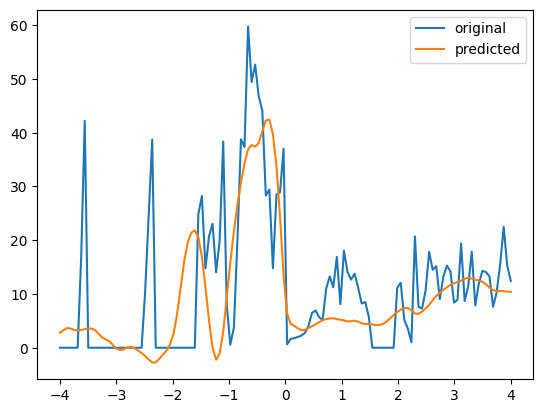

In [16]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,median_absolute_error
ytest    = dbresults['y'][testidx]
x4t      = dbresults['x4'][testidx]
predtest = dbresults['preds'][testidx]
mset = np.asarray([mean_squared_error(i,j) for i,j in zip(ytest,predtest)])
maet = np.asarray([mean_absolute_error(i,j) for i,j in zip(ytest,predtest)])
mseTt=np.mean(mset)
maeTt=np.mean(maet)
print('MSE_test: ',mseTt,'MAE_test: ',maeTt)
#formula = [dbresults['formula'][i] for i in testidx]
#ids = [dbresults['ids'][i] for i in testidx]
ind=np.random.randint(len(ytest))
p = np.random.permutation(np.where(mset>0.)[0])
ind=p[0]#np.random.randint(len(ytrain))
y_true = ytest[ind]
y_pred = predtest[ind]
plt.plot(x4t[ind],y_true,label='original')
plt.plot(x4t[ind],gaussian_filter1d(y_pred,1),label='predicted')
#plt.plot(x4t[ind],gaussian_filter1d(y_true,1))
print('mean_squared_error: ',mean_squared_error(y_true,y_pred))
print('mean_absolute_error: ',mean_absolute_error(y_true,y_pred))
#plt.title(formula[ind].translate(sub), fontsize=16)
plt.legend();